In [1]:
import numpy as np
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
import random
import folium
wr.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
pip install mapbox

In [ ]:
from mapbox import Geocoder


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Thesis/geo-reviews-dataset-2023.csv')
df.head(5)

In [ ]:
import requests

# Initialize Mapbox parameters
MAPBOX_API_URL = "https://api.mapbox.com/geocoding/v5/mapbox.places"
ACCESS_TOKEN = 'sk.eyJ1IjoiaXRzZGFyd2lucyIsImEiOiJjbTNrY2xlNnEwYW5nMmxxendvd2dsenI5In0.usJu3VHs43DM9bv1OWMjHA'

def create_batches(data, batch_size):
    for i in range(0, len(df), batch_size):
        yield data[i:i + batch_size]

# Function to batch geocode addresses
def batch_geocode(batch):
    results = []
    for address in batch:
        response = requests.get(f"{MAPBOX_API_URL}/{address}.json", params={"access_token": ACCESS_TOKEN, "limit": 1})
        if response.status_code == 200:
            features = response.json().get("features", [])
            if features:
                coords = features[0]["geometry"]["coordinates"]
                results.append((address, coords))
            else:
                results.append((address, None))
        else:
            results.append((address, None))
    return results

citiDF = df

# Filter for Moscow addresses
moscow_addresses = citiDF[citiDF['address'].str.contains('Moscow|Москва', case=False, na=False)]
addresses = moscow_addresses['address'].tolist()




In [ ]:
# Split into batches
batch_size = 100
batches = list(create_batches(addresses, batch_size))


In [ ]:
len(batches)
for i, batch in enumerate(batches):
    print(f"Batch {i + 1}: {len(batch)} rows")

In [ ]:
batches = [batch for batch in batches if len(batch) > 0]

In [ ]:
print(f"Total number of non-empty batches: {len(batches)}")
for i, batch in enumerate(batches):
    print(f"Batch {i + 1}: {len(batch)} rows")


In [ ]:

all_results = []
for i, batch in enumerate(batches):
    print(f"Processing batch {i + 1} of {len(batches)}...")
    results = batch_geocode(batch)
    all_results.extend(results)

geocoded_df = pd.DataFrame(all_results, columns=["address", "latlong"])
geocoded_df["latitude"] = geocoded_df["latlong"].apply(lambda x: x[1] if x else None)
geocoded_df["longitude"] = geocoded_df["latlong"].apply(lambda x: x[0] if x else None)

geocoded_df.to_csv("geocoded_addresses.csv", index=False)

files.download('geocoded_addresses.csv')

In [ ]:
heat_data = geocoded_df[['latitude', 'longitude']].values.tolist()

m = folium.Map(location=[55.7558, 37.6173], zoom_start=11)
HeatMap(heat_data, radius=10, blur=15).add_to(m)

m.save("moscow_heatmap.html")
m

In [ ]:
geocoded_addresses_df = pd.read_csv('/content/drive/MyDrive/Thesis/geocoded_addresses.csv')
geocoded_addresses_df.head(5)

In [ ]:
merged_data = pd.merge(moscow_addresses, geocoded_addresses_df, on='address', how='left')
data = merged_data.drop_duplicates()

In [ ]:
import re

def preprocess_text(text):
    text = text.lower().strip()
    stopwords = ['и', 'на', 'с', 'для']
    text = ' '.join([word for word in text.split() if word not in stopwords])

    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    return text

In [ ]:
!pip install openai==0.28

In [ ]:
import openai
openai.api_key =

In [ ]:
unique_rubrics_df = data['rubrics'].drop_duplicates().reset_index(drop=True)
unique_rubrics_df

In [ ]:
import time
import openai
import pandas as pd

# Define the rubric list
rubric_list = [
    "кафе", "ресторан", "бар", "магазин подарков и сувениров",
    "торговые центры", "магазин одежды и модной одежды", "супермаркет / продуктовый магазин", 'рынок', 'государственные услуги'
    "магазин электроники и специализированных товаров", "медицинские услуги", "салон красоты", "оптические услуги",
    "фитнес и спорт", 'строительное оборудование и техника',  "грузоперевозки и грузовые услуги", "аренда транспортных средств",
    "кинотеатры и кинозалы", "развлечения и отдых", "ателье", "гостиницы и хостелы", "жилые комплексы",
    'спортивный магазин', 'различные услуги', "коммерческая недвижимость", "услуги для домашних животных",'магазин детских товаров', "образовательные услуги",
    'магазин парфюмерии и косметики', 'товары и мебель для дома', "парикмахерская", "авто услуги", 'магазин хозтоваров и бытовой химии', 'турагентство',
    'ремонтные услуги',"художественные галереи и музеи", "культурные центры", 'вокзалы', 'станция', 'магазин цветов','магазин быстрого питания', 'банк'
]

def get_best_match_with_gpt(rubric, rubric_list, retries=3, delay=5):
    prompt = f"Given the rubric '{rubric}', suggest the most appropriate category from the following list: {rubric_list}. Please return only one rubric category from the list without extra characters or multiple options."

    for attempt in range(retries):
        try:
            # Make the API request to GPT
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[{"role": "system", "content": "You are an assistant that helps with categorizing rubrics."},
                          {"role": "user", "content": prompt}],
                max_tokens=100,
                n=1,
                stop=None,
                temperature=0.5
            )

            best_match = response['choices'][0]['message']['content'].strip()

            best_match = best_match.replace("'", "").replace('"', '').strip()

            return best_match
        except openai.error.OpenAIError as e:
            print(f"Attempt {attempt+1} failed: {e}")
            if attempt < retries - 1:
                time.sleep(delay)
            else:
                print("Max retries reached. Skipping...")
                return None

output_file_path = '/content/drive/MyDrive/Thesis/rubrics/processed_rubrics.csv'

batch_size = 10
batches = [unique_rubrics_df.iloc[i:i + batch_size] for i in range(0, len(unique_rubrics_df), batch_size)]

all_new_rubrics = []

with open(output_file_path, 'w') as f:
    total_batches = len(batches)
    for batch_num, batch in enumerate(batches, start=1):
        new_rubrics = []

        for rubric in batch:
            best_match = get_best_match_with_gpt(rubric, rubric_list)
            new_rubrics.append(best_match)

        all_new_rubrics.extend(new_rubrics)

        batch_df = pd.DataFrame({'rubrics': batch.tolist(), 'new_rubrics': new_rubrics})

        batch_df.to_csv(f, mode='a', header=f.tell() == 0, index=False)

        print(f"Processed Batch {batch_num}/{total_batches}")

unique_rubrics_df['new_rubrics'] = all_new_rubrics

unique_rubrics_df

In [ ]:
rubrics = pd.read_csv('/content/drive/MyDrive/Thesis/rubrics/processed_rubrics.csv')
rubrics.head(10)

In [ ]:
rubrics['new_rubrics'] = rubrics['new_rubrics'].str.lower()
rubric_map = pd.Series(rubrics['new_rubrics'].values, index=rubrics['rubrics']).to_dict()

data['rubrics'] = data['rubrics'].map(rubric_map).fillna(data['rubrics'])  # Use fillna to keep unmatched rubrics as is


data

In [ ]:
pd.set_option('display.max_colwidth', None)

unique_rubric = data['rubrics'].drop_duplicates().reset_index(drop=True)
unique_rubric.head(30)

In [ ]:
#Checking to see how much are in the list
rubric_list = [
    "кафе", "ресторан", "бар", "магазин подарков и сувениров", 'супермаркет / продуктовый магазин',
    "торговые центры", "магазин одежды и модной одежды",'рынок', 'государственные услуги', 'религиозное объединение',
    "магазин электроники и специализированных товаров", "медицинские услуги", "салон красоты", "оптические услуги",
    "фитнес и спорт", 'строительное оборудование и техника',  "грузоперевозки и грузовые услуги", "аренда транспортных средств",
    "кинотеатры и кинозалы", "развлечения и отдых", "ателье", "гостиницы и хостелы", "жилые комплексы",
    'спортивный магазин', 'различные услуги', "коммерческая недвижимость", "услуги для домашних животных",'магазин детских товаров', "образовательные услуги",
    'магазин парфюмерии и косметики', 'товары и мебель для дома', "парикмахерская", "авто услуги", 'магазин хозтоваров и бытовой химии', 'турагентство',
    'ремонтные услуги',"художественные галереи и музеи", "культурные центры", 'вокзалы', 'станция', 'магазин цветов','магазин быстрого питания', 'банк'
]

matching_rows = data[data['rubrics'].str.lower().isin([r.lower() for r in rubric_list])]
print(f' Number of rows is: {len (matching_rows)}')

In [ ]:
non_matching_rows = data[~data['rubrics'].str.lower().isin([r.lower() for r in rubric_list])]

non_matching_rows

In [ ]:
# Manually changing the wrong rubrics
manual_changes = {
    'mагазин одежды и модной одежды': 'магазин одежды и модной одежды',
    'mагазин цветов': 'магазин цветов',
    'фотоуслуги -> различные услуги': 'различные услуги',
    'the most appropriate category for the rubric медцентр, клиника;стоматологическая поликлиника;диагностический центр;гинекологическая клиника;травмпункт;детская поликлиника;косметология is медицинские услуги': 'медицинские услуги',
    'выставочный центр - культурные центры' : 'культурные центры',
    'детский сад':  "образовательные услуги",
    'the most appropriate category for the rubric мебель для кухни;мебель на заказ;магазин мебели;корпусная мебель is товары и мебель для дома': 'товары и мебель для дома',
    'мебель для дома': 'товары и мебель для дома',
    'магазин чая;кондитерская;магазин кофе -> кафе': 'кафе',
    'the most appropriate category for the rubric окна;остекление балконов и лоджий;изготовление витражей;двери would be строительное оборудование и техника': 'строительное оборудование и техника',
    'the most appropriate category for the rubric архив;архивные услуги is коммерческая недвижимость': 'государственные услуги',
    'адвокаты;юридические услуги would most appropriately fall under the category юридические услуги': 'различные услуги',
    'the most appropriate category for the rubric стоматологическая поликлиника;стоматологическая клиника;зуботехническая лаборатория would be медицинские услуги' : 'медицинские услуги',
    'магазин питьевой продукции' : 'супермаркет / продуктовый магазин',
    'спортбар' : 'бар',
    'коворкинг - коммерческая недвижимость': "коммерческая недвижимость",
    'ночной клуб;бар, паб;кальян-бар - развлечения и отдых': 'бар',
    'художественные галереи' : "художественные галереи и музеи",
    'the most appropriate category for the rubric светодиодные системы освещения;светотехника;светильники would be магазин электроники и специализированных товаров': 'магазин электроники и специализированных товаров',
    'развлекательный центр: развлечения и отдых': 'развлечения и отдых',
    'церковь': 'религиозное объединение',
    'salon красоты': 'салон красоты',
    'the most appropriate category for the rubric фитнес-клуб;студия йоги;спортивный, тренажёрный зал is фитнес и спорт': 'фитнес и спорт',
    'газовая заправка (азс)' : 'авто услуги',
    'the most appropriate category for the rubric медцентр, клиника;диагностический центр;медицинская лаборатория;остеопатия is медицинские услуги': 'медицинские услуги',
    'beauty salon': 'салон красоты',
    'коворкинг': "коммерческая недвижимость",
    'remontnye uslugi (ремонтные услуги)': 'ремонтные услуги',
    'mагазин детских товаров': 'магазин детских товаров',
    'достопримечательность - культурные центры': 'культурные центры',
    'magazin podarkov i suvenirov': 'магазин подарков и сувениров',
    'remontnie uslugi': 'ремонтные услуги',
    'the most appropriate category for the rubric медцентр, клиника;стоматологическая клиника;косметология is медицинские услуги': 'медицинские услуги',
    'магазин товаров для дома': 'товары и мебель для дома',
    'магазин строительных материалов': 'строительное оборудование и техника',
    'супермаркет   продуктовый магазин	': 'супермаркет / продуктовый магазин',
    'sалон красоты': 'салон красоты',
    'супермаркет продуктовый магазин' : 'супермаркет / продуктовый магазин',
    'супермаркет продуктовый магазин': 'супермаркет / продуктовый магазин',
    'магазин мебели':'товары и мебель для дома',
    'the most appropriate category for the rubric технопарк;учебный центр;клуб для детей и подростков is образовательные услуги.':  "образовательные услуги",
    'фаст-фуд': "ресторан",
    'supermarket / продуктовый магазин': 'супермаркет / продуктовый магазин',
    'the most appropriate category for the rubric салон красоты;массажный салон;эпиляция is салон красоты.': 'салон красоты',
    'remontnye uslugi': 'ремонтные услуги',
    'the most appropriate category for the rubric бизнес-школа;тренинги;бизнес-консалтинг is образовательные услуги.': 'образовательные услуги',
    'пункт выдачи - магазин одежды и модной одежды': 'магазин одежды и модной одежды',
    'remontnye uslugi (repair services)': 'ремонтные услуги',
    'магазин подарков и сувениров.': 'магазин подарков и сувениров',
    'салон красоты - красота': 'салон красоты',
    'the most appropriate category for the rubric энергетическая организация is кафе.': 'государственные услуги',
    'mагазин электроники и специализированных товаров': 'магазин электроники и специализированных товаров',
    'магазин одежды': 'магазин одежды и модной одежды',
    'банк - коммерческая недвижимость':'банк',
    'магазин продуктов - супермаркет / продуктовый магазин':'супермаркет / продуктовый магазин',
    'быстрое питание': 'магазин быстрого питания',
    'магазин хозтоваров и бытовой химии - супермаркет / продуктовый магазин': 'магазин хозтоваров и бытовой химии',
    'магазин для домашних животных': 'услуги для домашних животных',
    'restaurant': 'ресторан',
    'магазин бытовой химии': 'магазин хозтоваров и бытовой химии',
    'магазин продуктовый / супермаркет': 'супермаркет / продуктовый магазин',
    'банкомат - финансовые услуги': 'банк',
    'mагазин подарков и сувениров': 'магазин подарков и сувениров',
    'magazin odezdy i modnoy odezdy': 'магазин одежды и модной одежды',
    '[библиотека] should be categorized under культурные центры.' : 'культурные центры',
    'sупермаркет / продуктовый магазин': 'супермаркет / продуктовый магазин',
    'азс': 'авто услуги',
    'азс - авто услуги': 'авто услуги',
    'магазин продуктовый': 'супермаркет / продуктовый магазин',
    'магазин электроники и специализированных товаров.': 'магазин электроники и специализированных товаров',
    'magazin odezhdy i modnoy odezhdy': 'магазин одежды и модной одежды',
    'магазин продуктов': 'супермаркет / продуктовый магазин',
    'юридические услуги' : 'консалтинговые услуги',
    'магазин суши и азиатских продуктов': 'ресторан',
    'mагазин обуви corresponds to the category магазин одежды и модной одежды.':'магазин одежды и модной одежды',
    'mедицинские услуги':'медицинские услуги',
    'магазин продуктовый.': 'супермаркет / продуктовый магазин',
    'магазин спортивного инвентаря и оборудования' : 'спортивный магазин',
    'ночной клуб': 'развлечения и отдых',
    "консалтинговые услуги" : 'различные услуг',
    'рекламная продукция': 'различные услуг' ,
    'полиграфические услуги': 'различные услуг',
    'категория: магазин сантехники': 'магазин хозтоваров и бытовой химии',
    'магазин услуг для домашних животных': 'услуги для домашних животных',
    'магазин продуктов.': 'супермаркет / продуктовый магазин',
    'магазин':'супермаркет / продуктовый магазин',
    'места проведения мероприятий.': "места проведения мероприятий",
    'товары для дома':  'товары и мебель для дома',
    'мебельный магазин':  'товары и мебель для дома',
    'мебель для кухни - магазин электроники и специализированных товаров.':  'товары и мебель для дома',
    'магазин парфюмерии и косметики;пункт выдачи: магазин одежды и модной одежды': 'магазин парфюмерии и косметики',
    'ремонт обуви - ателье': 'ателье',
    'различные услуг': 'различные услуги',
    'mебель на заказ': 'товары и мебель для дома',
    'магазин сантехники': 'магазин хозтоваров и бытовой химии',
    'magazin odezhdy': 'магазин одежды и модной одежды',
    'фотостудия': 'различные услуги',
    'магазин спортивного инвентаря' : 'спортивный магазин',
    'офисные услуги': 'различные услуги',
    'магазин текстиля': 'товары и мебель для дома',
    'музей': "художественные галереи",
    'автосалон': 'авто услуги',
    'строительный магазин': 'строительное оборудование и техника',
    'стройматериалы оптом': 'строительное оборудование и техника',
    'сельскохозяйственная техника, оборудование': 'строительное оборудование и техника',
    'магазин пляжных товаров': 'спортивный магазин',
    'обучение': "образовательные услуги",
    'торговое оборудование': 'строительное оборудование и техника',
    'ремонт обуви': 'ателье',
    'рекламное агентство': 'различные услуги',
    'магазин парфюмерии и косметики - магазин одежды и модной одежды': 'магазин парфюмерии и косметики',
    'ритуальные услуги': 'различные услуги',
    'the most appropriate category for the rubric светильники;светотехника;камины, печи is магазин электроники и специализированных товаров.': 'товары и мебель для дома',
    'магазин кулинарии': 'кафе',
    'магазин одежды и модной одежды.': 'магазин одежды и модной одежды',
    'магазин суши и азиатских продуктов - быстрое питание': 'магазин быстрого питания',
    'развлекательный центр': "развлечения и отдых",
    'магазин продуктового суши': 'магазин быстрого питания',
    'магазин кулинарии - магазин продуктового питания': 'кафе',
    'гастромаркет': 'магазин быстрого питания',
    'магазин суши и азиатских продуктов - быстрое питание': 'магазин быстрого питания',
    'магазин автозапчастей и автотоваров': 'авто услуги',
    'магазин чая' : 'супермаркет / продуктовый магазин',
    'the most appropriate category for the rubric программное обеспечение;хостинг;студия веб-дизайна is магазин электроники и специализированных товаров.': 'различные услуги',
    'магазин обуви': 'магазин одежды и модной одежды',
    'магазин часов':  'магазин электроники и специализированных товаров',
    'агнс, агзс, агнкс - авто услуги': 'авто услуги',
    'кофе с собой - быстрое питание': 'магазин быстрого питания',
    'продуктовый магазин': 'супермаркет / продуктовый магазин',
    'ремонт одежды': 'ателье',
    'сервисные услуги': 'различные услуги',
    'магазин кулинарии - магазин продуктовый': 'магазин быстрого питания',
    'it-компания': 'различные услуги',
    'mагазин обоев belongs to the category магазин электроники и специализированных товаров.': 'товары и мебель для дома',
    'магазин специализированных товаров': 'магазин электроники и специализированных товаров',
    'туризм': 'турагентство',
    'магазин для садоводов': 'строительное оборудование и техника',
    'мебельные магазины': 'товары и мебель для дома',
    'типография': 'различные услуги',
    'mагазин цветов corresponds to the category магазин подарков и сувениров.' : 'магазин цветов',
    'развлечения и отдых.':  "развлечения и отдых",
    'бизнес-консалтинг':  'различные услуги',
    'mагазин продуктов': 'супермаркет / продуктовый магазин',
    'магазин электроники': 'магазин электроники и специализированных товаров',
    'магазин электротоваров': 'магазин электроники и специализированных товаров',
    'магазин суши и азиатских продуктов - магазин продуктов': 'магазин быстрого питания',
    'контрольно-измерительные приборы;автоматизация производств;электротехническая продукция corresponds to магазин электроники и специализированных товаров.': 'магазин электроники и специализированных товаров',
    'туристический информационный центр': 'турагентство',
    'магазин посуды' : 'товары и мебель для дома',
    'мебель на заказ' : 'товары и мебель для дома',
    'клининговые услуги' : 'различные услуги',
    'магазин алкогольных напитков': 'супермаркет / продуктовый магазин',
    'производственное предприятие - коммерческая недвижимость' : "коммерческая недвижимость",
    'mагазин мебели' : 'товары и мебель для дома',
    'мебельная фабрика': 'товары и мебель для дома',
    'мебельные магазины.': 'товары и мебель для дома',
    'магазин автозапчастей - авто услуги' : 'авто услуги',
    'экспертиза - консалтинговые услуги': 'различные услуги',
    'художественная мастерская' : "развлечения и отдых",
    'nightclub' : "развлечения и отдых",
    'суши-бар' : 'бар',
    'банкетный зал': "места проведения мероприятий",
    'supermarket / grocery store': 'супермаркет / продуктовый магазин',
    'архивные услуги - коммерческая недвижимость': "коммерческая недвижимость",
    'пиццерия' : 'магазин быстрого питания',
    'магазин обоев': 'товары и мебель для дома',
    'фотоуслуги' : 'различные услуги',
    'магазин кофе' : 'магазин быстрого питания',
    'пенсионный фонд - консалтинговые услуги.': 'различные услуги',
    'the most appropriate category for the rubric типография;рекламная продукция;полиграфические услуги is коммерческая недвижимость.': 'различные услуги',
    'магазин кулинарии - супермаркет / продуктовый магазин': 'магазин быстрого питания',
    'информационный интернет-сайт - культурные центры.' : 'различные услуги',
    'сантехнические работы' : 'ремонтные услуги',
    'металлоремонт' : 'ремонтные услуги',
    'промышленная очистка сооружений и оборудования': 'ремонтные услуги',
    'ремонт велосипедов' : 'ремонтные услуги',
    'обслуживание систем водоснабжения и канализации.': 'ремонтные услуги',
    'мастерская' :'ремонтные услуги',
    'ремонтные уювелирная мастерская' : 'ремонтные услуги',
    'бытовые услуги' : 'ремонтные услуги',
    'фитнес и спорт.' : 'фитнес и спорт',
    'магазин продуктовой компании': 'магазин быстрого питания',
    'ночной клуб - развлечения и отдых': "развлечения и отдых",
    'кофейня': 'кафе',
    'креативные услуги': 'различные услуги',
    'magazin elektroniki i spetsializirovannykh tovarov': 'магазин электроники и специализированных товаров',
    'магазины': 'товары и мебель для дома',
    'магазин для домашних животных.': "услуги для домашних животных",
    'ювелирная мастерская': 'ремонтные услуги',
    'the most appropriate category for the rubric мебель для офиса;детская мебель is магазин одежды и модной одежды.': 'товары и мебель для дома',
    'отдых и развлечения': "развлечения и отдых",
    'mагазин обуви': 'магазин одежды и модной одежды',
    'магазин товаров для курения' : 'супермаркет / продуктовый магазин',
    'промышленное оборудование': 'строительное оборудование и техника',
    'рекламное оборудование и материалы' : 'строительное оборудование и техника',
    'строительные и отделочные работы' : 'строительное оборудование и техника',
    'бухгалтерские услуги would fall under the category консалтинговые услуги.' :  'различные услуги',
    'магазин постельных принадлежностей' : 'товары и мебель для дома',
    'доставка еды и обедов - быстрое питание': 'магазин быстрого питания',
    'котлы и котельное оборудование': 'строительное оборудование и техника',
    'котлы и котельное оборудование;системы водоснабжения и канализации;монтаж и обслуживание систем водоснабжения и канализации corresponds to the category грузоперевозки и грузовые услуги.': 'строительное оборудование и техника',
    'мебель для кухни;мебель на заказ - магазин мебели' : 'товары и мебель для дома',
    'магазин суши и азиатских продуктов - супермаркет / продуктовый магазин': 'супермаркет / продуктовый магазин',
    'магазин автозапчастей и автотоваров;автокосметика, автохимия;смазочные материалы corresponds to авто услуги.': 'авто услуги',
    'сантехнические работы - авто услуги': 'ремонтные услуги',
    'кондитерская': 'магазин быстрого питания',
    'мастерская/ателье': 'ателье',
    'the most appropriate category for the rubric облицовочные материалы;фасады и фасадные системы;фотообои и фрески would be коммерческая недвижимость.': 'строительное оборудование и техника',
    'from the list provided, the most appropriate category for the rubric караоке-клуб;кафе;кальян-бар would be бар.': 'бар',
    'the most appropriate category for the rubric строительный магазин;магазин сантехники;напольные покрытия is строительное оборудование и техника.': 'строительное оборудование и техника',
    'the most appropriate category for the rubric ювелирные камни;ювелирный магазин;ювелирное оборудование is магазин подарков и сувениров.': 'магазин подарков и сувениров',
    'the most appropriate category for the rubric печати и штампы;полиграфические услуги;типография is полиграфические услуги.' : 'различные услуги',
    'зооцентр, клуб любителей животных - услуги для домашних животных': 'услуги для домашних животных',
    'супермаркет  продуктовый магазин': 'супермаркет / продуктовый магазин'

}

data['rubrics'] = data['rubrics'].replace(manual_changes)


In [ ]:
output_path = '/content/drive/MyDrive/Thesis/rubrics/new_rubric.csv'

data.to_csv(output_path, index=False)

print(f"Data has been saved to: {output_path}")

In [ ]:
rubric_address_counts = data.groupby('rubrics')['address'].nunique().reset_index()

rubric_address_counts.columns = ['rubric', 'unique_address_count']
rubric_address_counts = rubric_address_counts.sort_values(by='unique_address_count', ascending=False)
top_rubrics_by_address = rubric_address_counts.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='unique_address_count', y='rubric', data=top_rubrics_by_address, palette='viridis')
plt.title(f'Top 10 Rubrics by Number of Unique Addresses')
plt.xlabel('Number of Unique Addresses')
plt.ylabel('Rubric')
plt.show()

In [ ]:
Moscow_Borough_df = pd.read_csv('/content/drive/MyDrive/Thesis/Moscow_Borough_df.csv')
Moscow_Borough_df.head(5)

In [ ]:
def find_nearest_borough(row):
    distances = ((Moscow_Borough_df['Latitude'] - row['latitude']) ** 2 +
                  (Moscow_Borough_df['Longitude'] - row['longitude']) ** 2) ** 0.5
    nearest_borough_index = distances.idxmin()
    return pd.Series([Moscow_Borough_df.loc[nearest_borough_index, 'Borough_Name'],
                      Moscow_Borough_df.loc[nearest_borough_index, 'Latitude'],
                      Moscow_Borough_df.loc[nearest_borough_index, 'Longitude']])

moscow_rubric_processed[['Borough_Name', 'Borough_Latitude', 'Borough_Longitude']] = moscow_rubric_processed.apply(find_nearest_borough, axis=1)

moscow_rubric_processed.head(10)

In [ ]:
import time
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import folium
from folium.plugins import MarkerCluster
import zipfile
from zipfile import ZipFile
from io import BytesIO
from google.colab import files

cmap = cm.get_cmap('YlOrRd')  # Using a yellow-to-red gradient
data_unique = data.drop_duplicates(subset=['address'])

most_dense = data_unique.groupby(['rubrics', 'Borough_Name']).size().reset_index(name='count')

batch_size = 7
rubric_batches = [most_dense['rubrics'].unique()[i:i + batch_size] for i in range(0, len(most_dense['rubrics'].unique()), batch_size)]

zip_buffer = BytesIO()

with ZipFile(zip_buffer, 'w', zipfile.ZIP_DEFLATED) as zipf:

    for batch_num, batch in enumerate(rubric_batches):
        for rubric in batch:

            rubric_data = most_dense[most_dense['rubrics'] == rubric]

            norm = mcolors.Normalize(vmin=rubric_data['count'].min(), vmax=rubric_data['count'].max())

            m = folium.Map(location=[55.7558, 37.6173], zoom_start=12)

            marker_cluster = MarkerCluster().add_to(m)

            for _, row in rubric_data.iterrows():
                avg_lat = data[data['Borough_Name'] == row['Borough_Name']]['latitude'].mean()
                avg_lon = data[data['Borough_Name'] == row['Borough_Name']]['longitude'].mean()

                if pd.notna(avg_lat) and pd.notna(avg_lon):
                    density_normalized = norm(row['count'])
                    color = mcolors.to_hex(cmap(density_normalized))

                    folium.CircleMarker(
                        location=(avg_lat, avg_lon),
                        radius=15 + (row['count'] * 2),
                        color=color,
                        fill=True,
                        fill_color=color,
                        fill_opacity=0.6,
                        popup=f"<b>Borough:</b> {row['Borough_Name']}<br><b>Rubric:</b> {row['rubrics']}<br><b>Count:</b> {row['count']}",
                        tooltip=f"<b>{row['Borough_Name']}</b><br><b>{row['rubrics']}</b>",
                    ).add_to(marker_cluster)

            legend_html = '<div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: auto; background-color: white; z-index:9999; font-size:14px; padding: 10px; border: 2px solid grey;">'
            legend_html += f'<b>Legend for {rubric}</b><br>'
            legend_html += '<div style="margin-top: 5px;">Density Gradient:</div>'
            for i in range(0, 101, 20):
                color = mcolors.to_hex(cmap(i / 100))
                legend_html += f'<div style="margin-top: 5px;"><span style="display: inline-block; width: 12px; height: 12px; background-color: {color}; margin-right: 10px;"></span>{i}%</div>'
            legend_html += '</div>'

            m.get_root().html.add_child(folium.Element(legend_html))

            sanitized_rubric = rubric.replace(' ', '_').replace('/', '_')

            map_html = m._repr_html_()

            map_filename = f"{sanitized_rubric}_moscow_map_batch_{batch_num + 1}.html"
            zipf.writestr(map_filename, map_html)

        print(f"Batch {batch_num + 1} processed!")

zip_buffer.seek(0)

with open("/maps_batches.zip", 'wb') as f:
    f.write(zip_buffer.read())

files.download("/maps_batches.zip")


In [23]:
df = pd.read_csv('/content/drive/MyDrive/Thesis/complete_data/complete_new_data.csv')
df.head(5)

,address,name_ru,rating,text,latitude,longitude,Nearest Metro Station,Distance to Nearest Metro (km),Borough_Name,Borough_Latitude,Borough_Longitude,rubrics
0,"Москва, 4-й Кожевнический переулок, 4",Jinju,5.0,"5 из 5🖤 Пил кофе и в Риме, и в Париже, но вку...",55.725157,37.649140,Москва-Пассажирская-Павелецкая,0.670489,Даниловский,55.707254,37.643518,кафе
1,"Москва, 4-й Кожевнический переулок, 4",Jinju,5.0,"5 из 5🖤 Пил кофе и в Риме, и в Париже, но вку...",55.725157,37.649140,Москва-Пассажирская-Павелецкая,0.670489,Даниловский,55.707254,37.643518,магазин быстрого питания
2,"Москва, 4-й Кожевнический переулок, 4",Jinju,4.0,"Не очень удобное расположение, от метро идти м...",55.725157,37.649140,Москва-Пассажирская-Павелецкая,0.670489,Даниловский,55.707254,37.643518,кафе
3,"Москва, 4-й Кожевнический переулок, 4",Jinju,4.0,"Не очень удобное расположение, от метро идти м...",55.725157,37.649140,Москва-Пассажирская-Павелецкая,0.670489,Даниловский,55.707254,37.643518,магазин быстрого питания
4,"Москва, улица Малая Дмитровка, 15",Healingbowl,5.0,Заказывала чашу онлайн. Перед этим посмотрела ...,55.769597,37.605075,Пушкинская,0.486149,Тверской,55.766250,37.607499,магазин подарков и сувениров


In [24]:
df = df.drop(columns = 'Nearest Metro Station')

In [26]:
df = df.drop(columns = 'Distance to Nearest Metro (km)')

In [27]:
df

,address,name_ru,rating,text,latitude,longitude,Borough_Name,Borough_Latitude,Borough_Longitude,rubrics
0,"Москва, 4-й Кожевнический переулок, 4",Jinju,5.0,"5 из 5🖤 Пил кофе и в Риме, и в Париже, но вку...",55.725157,37.649140,Даниловский,55.707254,37.643518,кафе
1,"Москва, 4-й Кожевнический переулок, 4",Jinju,5.0,"5 из 5🖤 Пил кофе и в Риме, и в Париже, но вку...",55.725157,37.649140,Даниловский,55.707254,37.643518,магазин быстрого питания
2,"Москва, 4-й Кожевнический переулок, 4",Jinju,4.0,"Не очень удобное расположение, от метро идти м...",55.725157,37.649140,Даниловский,55.707254,37.643518,кафе
3,"Москва, 4-й Кожевнический переулок, 4",Jinju,4.0,"Не очень удобное расположение, от метро идти м...",55.725157,37.649140,Даниловский,55.707254,37.643518,магазин быстрого питания
4,"Москва, улица Малая Дмитровка, 15",Healingbowl,5.0,Заказывала чашу онлайн. Перед этим посмотрела ...,55.769597,37.605075,Тверской,55.766250,37.607499,магазин подарков и сувениров
...,...,...,...,...,...,...,...,...,...,...
124947,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,5.0,Редко бываю здесь. В основном проездом в г. Ви...,55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы
124948,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,5.0,Отличный пересадочный узел. \n,55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы
124949,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,5.0,Хороший способ избежать автобусной пытки. Элек...,55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы
124950,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,4.0,"Охрана кривая но добрая, двери не закрываются ...",55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы


## **Metro Stations**

In [47]:
!pip install geojson


In [49]:
import json
from geojson import dump

# Read the data from the text file (make sure it's a valid JSON format)
with open('/content/drive/MyDrive/Thesis/complete_data/MCD1.txt') as json_file:  # name of the text file
    data = json.load(json_file)

# Convert JSON data to GeoJSON format and save it to a .geojson file
with open('MCD1.geojson', 'w') as f:  # output GeoJSON file
    dump(data, f)

# Check that the file is saved successfully
print("GeoJSON file created: MCD1.geojson")


GeoJSON file created: MCD1.geojson


In [50]:
from google.colab import files
files.download('/content/MCD1.geojson')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:

import geopandas as gpd


geojson_file = '/content/MCD1.geojson'
try:
    mcd = gpd.read_file(geojson_file, encoding='cp1251')
except UnicodeDecodeError:
    try:
        mcd = gpd.read_file(geojson_file, encoding='utf-8')
    except UnicodeDecodeError:
        try:
            mcd = gpd.read_file(geojson_file, encoding='latin1')
        except UnicodeDecodeError as e:
            raise UnicodeDecodeError(f"Failed to decode the GeoJSON file with common encodings. Original error: {e}")

In [52]:
mcd = pd.DataFrame(mcd)

In [53]:
import ast
import re
from shapely import wkt
from shapely.geometry import Point

def extract_station_name(attributes):
    try:
        # Try parsing using literal_eval if possible
        attributes_dict = ast.literal_eval(attributes)
        return attributes_dict.get("StationName", None)
    except Exception as e:
        # If literal_eval fails, use regex to extract 'StationName'
        match = re.search(r'"StationName":\s?"([^"]+)"', attributes)
        if match:
            return match.group(1)
        else:
            return None

mcd['StationName'] = mcd['attributes'].apply(extract_station_name)

def extract_coordinates(geometry):
    # If geometry is a string, parse it to a Point object
    if isinstance(geometry, str):
        geometry = wkt.loads(geometry)

    # Now check if the geometry is a Point object
    if isinstance(geometry, Point):
        longitude = geometry.x  # Longitude (x coordinate)
        latitude = geometry.y   # Latitude (y coordinate)
        return longitude, latitude
    else:
        return None, None

# Apply the function to the 'geometry' column to get latitude and longitude
mcd['Longitude'], mcd['Latitude'] = zip(*mcd['geometry'].apply(extract_coordinates))


# Now we only keep the columns 'StationName', 'Longitude', and 'Latitude'
mcd = mcd[['StationName', 'Longitude', 'Latitude']]

# Print the new DataFrame
print(mcd)

         StationName  Longitude   Latitude
0           Одинцово  37.281532  55.672189
1            Баковка  37.317476  55.683022
2           Сколково  37.342054  55.700230
3         Немчиновка  37.375731  55.716016
4             Сетунь  37.397316  55.723642
..               ...        ...        ...
134       Никольское  37.897155  55.759567
135     Салтыковская  37.921886  55.757805
136           Кучино  37.955118  55.752100
137          Ольгино  37.980808  55.751799
138  Железнодорожная  38.008458  55.752293

[139 rows x 3 columns]


In [54]:
metro = pd.read_csv('/content/drive/MyDrive/Thesis/data-624-2025-03-26.csv', sep = ';', header = 1)
metro

,Локальный идентификатор,Наименование,На территории Москвы,Административный округ,Район,Долгота в WGS-84,Широта в WGS-84,Тип вестибюля,Станция метрополитена,Линия,...,Режим работы по нечётным дням,Количество полнофункциональных БПА (все типы билетов),Количество малофункциональных БПА (билеты на 1 и 2 поездки),Общее количество БПА,Ремонт эскалаторов,Статус объекта,global_id,geoData,geodata_center,Unnamed: 21
0,331,"Китай-город, вход-выход 5 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631765,55.757328,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773539,"{coordinates=[37.63176509, 55.75732811], type=...","{coordinates=[37.63176509, 55.75732811], type=...",NaN
1,327,"Китай-город, вход-выход 4 в северный вестибюль",да,Центральный административный округ,Тверской район,37.630924,55.756733,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773540,"{coordinates=[37.63092407, 55.75673268], type=...","{coordinates=[37.63092407, 55.75673268], type=...",NaN
2,330,"Китай-город, вход-выход 7 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631862,55.757027,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773541,"{coordinates=[37.63186197, 55.75702717], type=...","{coordinates=[37.63186197, 55.75702717], type=...",NaN
3,322,"Китай-город, вход-выход 13 в южный вестибюль",да,Центральный административный округ,Тверской район,37.633207,55.752999,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773542,"{coordinates=[37.63320674, 55.7529987], type=P...","{coordinates=[37.63320674, 55.7529987], type=P...",NaN
4,321,"Китай-город, вход-выход 12 в южный вестибюль",да,Центральный административный округ,Таганский район,37.633566,55.753071,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773543,"{coordinates=[37.63356616, 55.75307131], type=...","{coordinates=[37.63356616, 55.75307131], type=...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,1413,"Авиамоторная, вход-выход 12 в вестибюль 2",да,Юго-Восточный административный округ,район Лефортово,37.716201,55.754405,подземный,Авиамоторная,Большая кольцевая линия,...,"открытие в 05:30:00, закрытие в 01:00:00, перв...",NaN,6.0,6.0,nested data,действует,2722038491,"{coordinates=[37.7162008, 55.75440481], type=P...","{coordinates=[37.7162008, 55.75440481], type=P...",NaN
1150,1414,"Авиамоторная, вход-выход 13 в вестибюль 2",да,Юго-Восточный административный округ,район Лефортово,37.715670,55.754439,подземный,Авиамоторная,Большая кольцевая линия,...,"открытие в 05:30:00, закрытие в 01:00:00, перв...",NaN,6.0,6.0,nested data,действует,2722038558,"{coordinates=[37.71566972, 55.75443866], type=...","{coordinates=[37.71566972, 55.75443866], type=...",NaN
1151,1415,"Каширская, выход 3 из вестибюля 1",да,Южный административный округ,район Нагатино-Садовники,37.649669,55.655972,подземный,Каширская,Замоскворецкая линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,2.0,2.0,4.0,nested data,действует,2722038638,"{coordinates=[37.64966862, 55.65597225], type=...","{coordinates=[37.64966862, 55.65597225], type=...",NaN
1152,1404,"Новомосковская, вход-выход 5 в вестибюль",да,Новомосковский административный округ,район Коммунарка,37.464904,55.559926,подземный,Новомосковская,Троицкая линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,6.0,NaN,6.0,nested data,действует,2722039384,"{coordinates=[37.46490422, 55.55992573], type=...","{coordinates=[37.46490422, 55.55992573], type=...",NaN


In [55]:
# Extract the station name (before the first comma in the 'Name' column)
metro['StationName'] = metro['Наименование'].apply(lambda x: x.split(',')[0])

# Extract the coordinates (Longitude and Latitude)
metro['Longitude'] = metro['Долгота в WGS-84']
metro['Latitude'] = metro['Широта в WGS-84']

# Create a new DataFrame with only the required columns
metro = metro[['StationName', 'Longitude', 'Latitude']]

# Display the final DataFrame
print(metro)

         StationName  Longitude   Latitude
0        Китай-город  37.631765  55.757328
1        Китай-город  37.630924  55.756733
2        Китай-город  37.631862  55.757027
3        Китай-город  37.633207  55.752999
4        Китай-город  37.633566  55.753071
...              ...        ...        ...
1149    Авиамоторная  37.716201  55.754405
1150    Авиамоторная  37.715670  55.754439
1151       Каширская  37.649669  55.655972
1152  Новомосковская  37.464904  55.559926
1153            Фили  37.515555  55.745337

[1154 rows x 3 columns]


In [56]:
from geopy.distance import geodesic

# Function to calculate geodesic centroid
def calculate_geodesic_centroid(coords):
    # Calculate the average latitude and longitude for a more precise calculation
    latitudes = [coord[0] for coord in coords]
    longitudes = [coord[1] for coord in coords]

    # Use the center of mass approach in geodesic space (weights are uniform)
    mean_lat = sum(latitudes) / len(latitudes)
    mean_lon = sum(longitudes) / len(longitudes)

    return (mean_lat, mean_lon)

# Group by 'StationName' and collect the coordinates
grouped = metro.groupby('StationName')

# Calculate the centroid for each group (station)
centroids = []
for name, group in grouped:
    coords = list(zip(group['Latitude'], group['Longitude']))  # List of coordinates
    centroid = calculate_geodesic_centroid(coords)
    centroids.append({'StationName': name, 'Centroid_Lat': centroid[0], 'Centroid_Lon': centroid[1]})

# Create a DataFrame of the centroids
centroid_df = pd.DataFrame(centroids)

# Display the centroids
print(centroid_df)


             StationName  Centroid_Lat  Centroid_Lon
0           Авиамоторная     55.752271     37.717010
1          Автозаводская     55.706953     37.659285
2          Академическая     55.687802     37.573465
3    Александровский сад     55.752085     37.610670
4           Алексеевская     55.807949     37.638623
..                   ...           ...           ...
263        Юго-Восточная     55.705622     37.817225
264         Юго-Западная     55.663679     37.483222
265                Южная     55.622317     37.608882
266              Ясенево     55.606232     37.533255
267            Яхромская     55.879932     37.545293

[268 rows x 3 columns]


In [57]:
centroid_df.rename(columns={
    'Centroid_Lat': 'Latitude',
    'Centroid_Lon': 'Longitude'
}, inplace=True)

metro = pd.concat([mcd[['StationName', 'Longitude', 'Latitude']], centroid_df[['StationName', 'Longitude', 'Latitude']]], ignore_index=True)
print(metro)


       StationName  Longitude   Latitude
0         Одинцово  37.281532  55.672189
1          Баковка  37.317476  55.683022
2         Сколково  37.342054  55.700230
3       Немчиновка  37.375731  55.716016
4           Сетунь  37.397316  55.723642
..             ...        ...        ...
402  Юго-Восточная  37.817225  55.705622
403   Юго-Западная  37.483222  55.663679
404          Южная  37.608882  55.622317
405        Ясенево  37.533255  55.606232
406      Яхромская  37.545293  55.879932

[407 rows x 3 columns]


In [25]:
import math

def haversine(coord1, coord2):
    """
    Calculate the great-circle distance between two points on the Earth's surface.

    Parameters:
    coord1 (tuple): Latitude and longitude of the first point (lat1, lon1).
    coord2 (tuple): Latitude and longitude of the second point (lat2, lon2).

    Returns:
    float: Distance in kilometers.
    """
    R = 6371.0

    lat1, lon1 = map(math.radians, coord1)
    lat2, lon2 = map(math.radians, coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

In [31]:

if 'Latitude' not in metro.columns or 'Longitude' not in metro.columns:
    raise ValueError("data metro must contain 'Latitude' and 'Longitude' columns.")
if 'latitude' not in df.columns or 'longitude' not in df.columns:
    raise ValueError("df DataFrame must contain 'latitude' and 'longitude' columns.")

nearest_metro_names = []
nearest_metro_distances = []

for idx, row in df.iterrows():
    address_lat = row['latitude']
    address_lon = row['longitude']

    nearest_metro = None
    min_distance = float('inf')

    for _, metro_row in metro.iterrows():
        metro_lat = metro_row['Latitude']
        metro_lon = metro_row['Longitude']

        distance = haversine((address_lat, address_lon), (metro_lat, metro_lon))

        if distance < min_distance:
            min_distance = distance
            nearest_metro = metro_row['StationName']

    nearest_metro_names.append(nearest_metro)
    nearest_metro_distances.append(min_distance)

df['Nearest Metro Station'] = nearest_metro_names
df['Distance to Nearest Metro (km)'] = nearest_metro_distances

print(df)

                                                  address  \
0                   Москва, 4-й Кожевнический переулок, 4   
1                   Москва, 4-й Кожевнический переулок, 4   
2                   Москва, 4-й Кожевнический переулок, 4   
3                   Москва, 4-й Кожевнический переулок, 4   
4                       Москва, улица Малая Дмитровка, 15   
...                                                   ...   
124947  Москва, Южный административный округ, район Би...   
124948  Москва, Южный административный округ, район Би...   
124949  Москва, Южный административный округ, район Би...   
124950  Москва, Южный административный округ, район Би...   
124951  Москва, Южный административный округ, район Би...   

                      name_ru  rating  \
0                       Jinju     5.0   
1                       Jinju     5.0   
2                       Jinju     4.0   
3                       Jinju     4.0   
4                 Healingbowl     5.0   
...                  

In [32]:
output_path = '/content/drive/MyDrive/Thesis/Data_with_new_metro.csv'
df.to_csv(output_path, index=False)

print(f"File saved to {output_path}")

File saved to /content/drive/MyDrive/Thesis/Data_with_new_metro.csv


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Thesis/Data_with_new_metro.csv')
df

,address,name_ru,rating,text,latitude,longitude,Borough_Name,Borough_Latitude,Borough_Longitude,rubrics,Nearest Metro Station,Distance to Nearest Metro (km)
0,"Москва, 4-й Кожевнический переулок, 4",Jinju,5.0,"5 из 5🖤 Пил кофе и в Риме, и в Париже, но вку...",55.725157,37.649140,Даниловский,55.707254,37.643518,кафе,Павелецкая,0.921711
1,"Москва, 4-й Кожевнический переулок, 4",Jinju,5.0,"5 из 5🖤 Пил кофе и в Риме, и в Париже, но вку...",55.725157,37.649140,Даниловский,55.707254,37.643518,магазин быстрого питания,Павелецкая,0.921711
2,"Москва, 4-й Кожевнический переулок, 4",Jinju,4.0,"Не очень удобное расположение, от метро идти м...",55.725157,37.649140,Даниловский,55.707254,37.643518,кафе,Павелецкая,0.921711
3,"Москва, 4-й Кожевнический переулок, 4",Jinju,4.0,"Не очень удобное расположение, от метро идти м...",55.725157,37.649140,Даниловский,55.707254,37.643518,магазин быстрого питания,Павелецкая,0.921711
4,"Москва, улица Малая Дмитровка, 15",Healingbowl,5.0,Заказывала чашу онлайн. Перед этим посмотрела ...,55.769597,37.605075,Тверской,55.766250,37.607499,магазин подарков и сувениров,Чеховская,0.461590
...,...,...,...,...,...,...,...,...,...,...,...,...
124947,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,5.0,Редко бываю здесь. В основном проездом в г. Ви...,55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы,Красный Строитель,1.316616
124948,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,5.0,Отличный пересадочный узел. \n,55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы,Красный Строитель,1.316616
124949,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,5.0,Хороший способ избежать автобусной пытки. Элек...,55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы,Красный Строитель,1.316616
124950,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,4.0,"Охрана кривая но добрая, двери не закрываются ...",55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы,Красный Строитель,1.316616


Nearest Metro and Average Rating

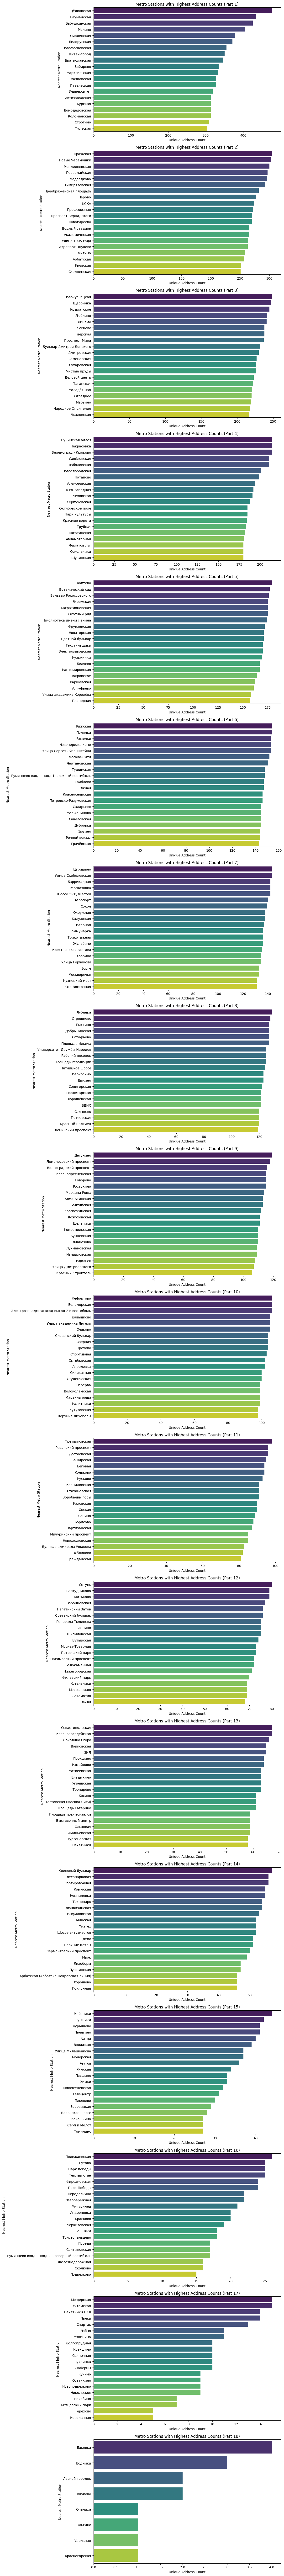

In [30]:
# Sort the metro station counts in descending order for better visualization
metro_counts = df.groupby('Nearest Metro Station')['name_ru'].nunique().reset_index(name='unique_address_count')
metro_counts = metro_counts.sort_values(by='unique_address_count', ascending=False)

# Define the number of metro stations to display per plot
num_metro_per_plot = 20

# Calculate the number of plots required
num_plots = (len(metro_counts) + num_metro_per_plot - 1) // num_metro_per_plot

# Create subplots based on the number of plots required
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 6 * num_plots))

# Ensure axes is a list if there's only one plot
if num_plots == 1:
    axes = [axes]

# Plot each subset
for i, ax in enumerate(axes):
    start = i * num_metro_per_plot
    end = (i + 1) * num_metro_per_plot
    subset = metro_counts.iloc[start:end]

    sns.barplot(x='unique_address_count', y='Nearest Metro Station', data=subset, palette='viridis', ax=ax)
    ax.set_title(f'Metro Stations with Highest Address Counts (Part {i+1})')
    ax.set_xlabel('Unique Address Count')
    ax.set_ylabel('Nearest Metro Station')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


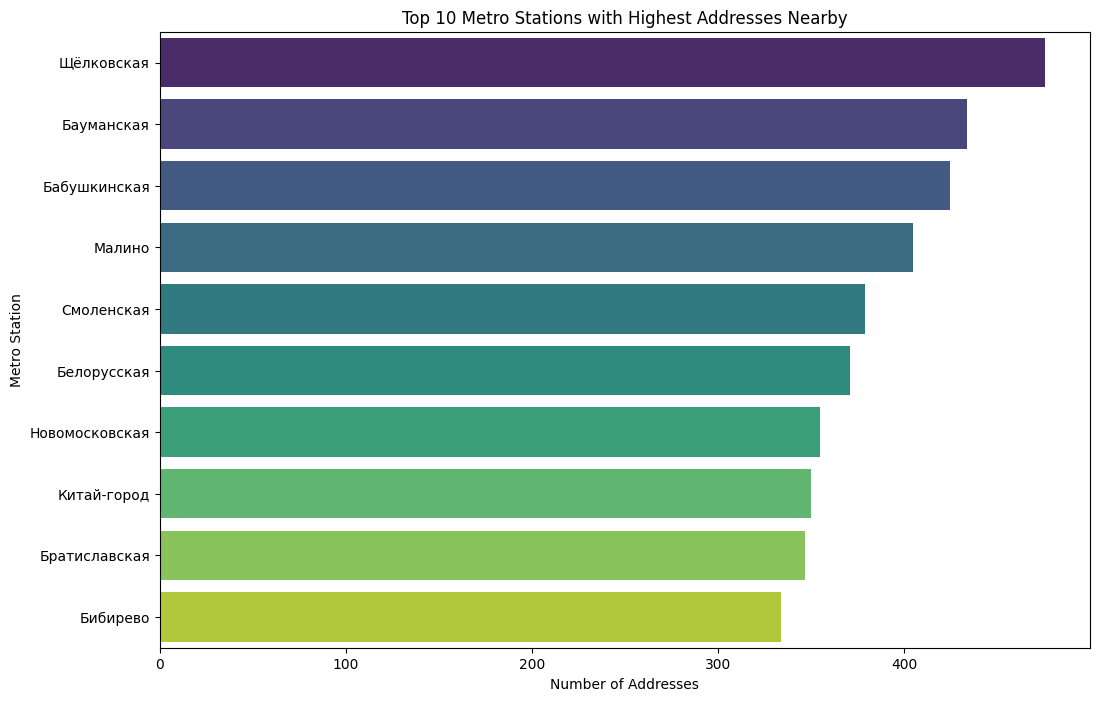

In [35]:
# Rename the columns for clarity
metro_counts.columns = ['Nearest Metro Station_1', 'unique_address_count']

# Sort the counts in descending order for better visualization
metro_counts = metro_counts.sort_values(by='unique_address_count', ascending=False)


top_metro = metro_counts.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='unique_address_count', y='Nearest Metro Station_1', data=top_metro, palette='viridis')
plt.title(f'Top 10 Metro Stations with Highest Addresses Nearby')
plt.xlabel('Number of Addresses')
plt.ylabel('Metro Station')
plt.show()

In [44]:
# Group by 'Nearest Metro Station' and calculate the average rating for each
metro_station_avg_rating = df.groupby('Nearest Metro Station')['rating'].mean().reset_index()

# Display the first few rows of the average ratings by metro station
metro_station_avg_rating.head()


,Nearest Metro Station,rating
0,Авиамоторная,4.342105
1,Автозаводская,4.376197
2,Академическая,4.439499
3,Алексеевская,4.376842
4,Алма-Атинская,4.172414


In [42]:
metro_station_avg_rating.nunique()

,0
Nearest Metro Station,348
rating,337
rating_count,282
rating_bin,3


  Nearest Metro Station rating_bin    rating
0          Авиамоторная       High  4.342105
1         Автозаводская       High  4.376197
2         Академическая       High  4.439499
3          Алексеевская       High  4.376842
4         Алма-Атинская     Medium  4.172414


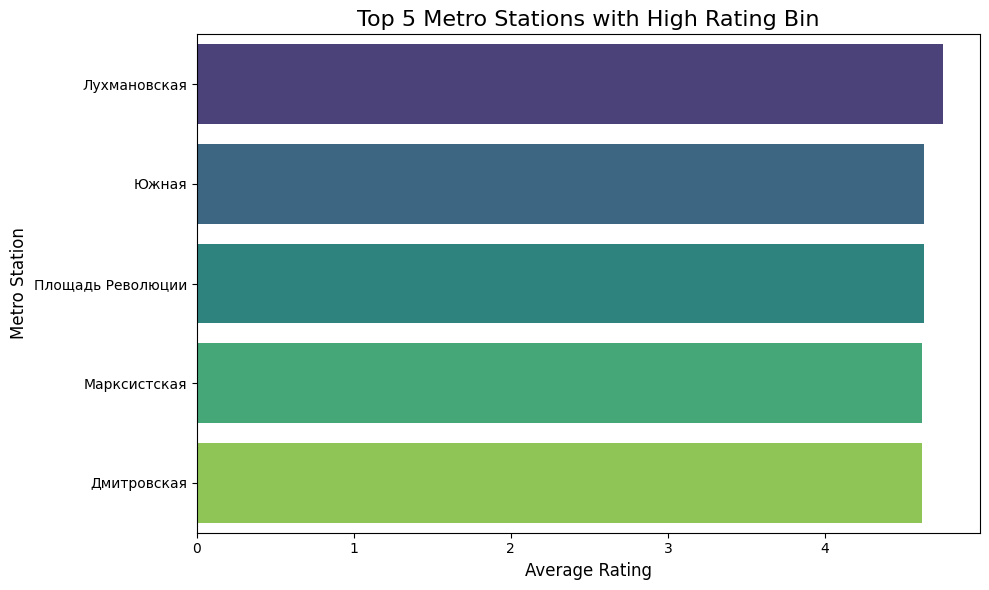

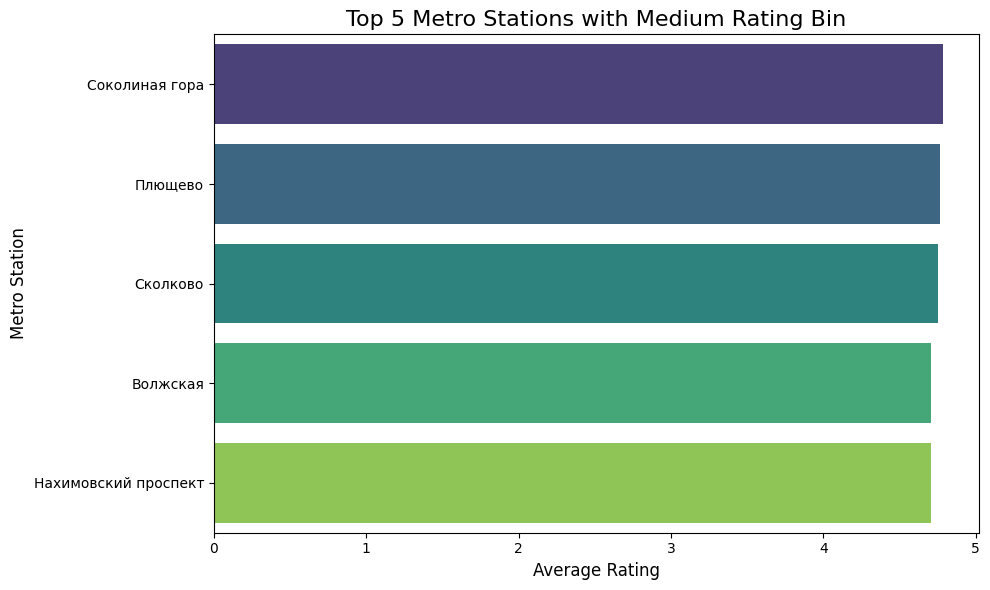

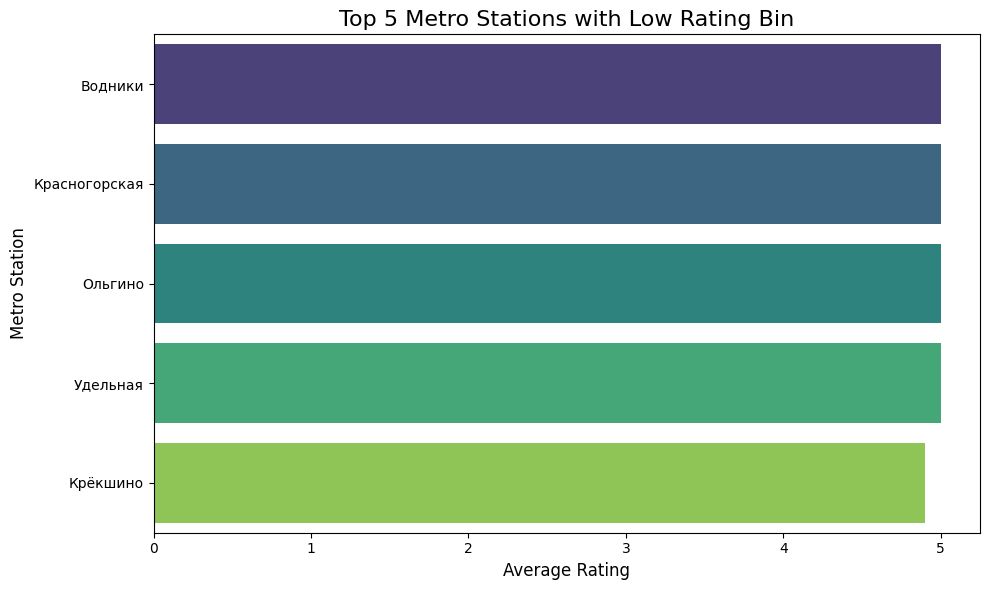

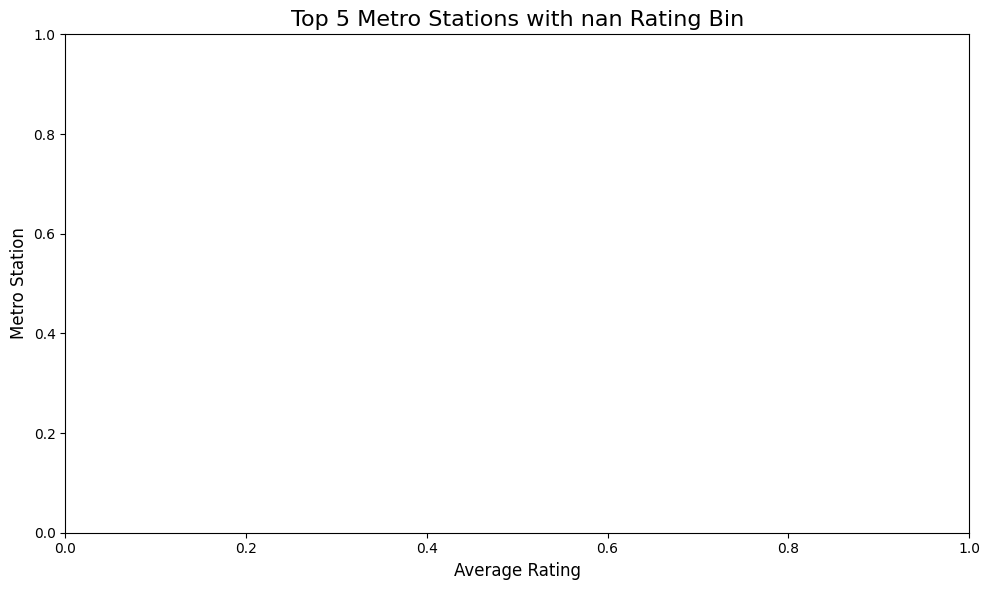

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate the number of ratings for each metro station
metro_station_rating_count = df.groupby('Nearest Metro Station')['rating'].count().reset_index()
metro_station_rating_count.rename(columns={'rating': 'rating_count'}, inplace=True)

# Bin the metro stations based on the number of ratings
bins = [0, 100, 300, 1000]
labels = ['Low', 'Medium', 'High']
metro_station_rating_count['rating_bin'] = pd.cut(metro_station_rating_count['rating_count'], bins=bins, labels=labels)

# Merge with the original data to compute weighted average by bin
metro_station_avg_rating = pd.merge(metro_station_avg_rating, metro_station_rating_count, on='Nearest Metro Station')

# Display the result
print(metro_station_avg_rating[['Nearest Metro Station', 'rating_bin', 'rating']].head())

# Group by rating bins and plot top 5 metro stations by average rating in each bin
rating_bins = metro_station_avg_rating['rating_bin'].unique()

for rating_bin in rating_bins:
    # Filter the data for the current rating bin
    bin_data = metro_station_avg_rating[metro_station_avg_rating['rating_bin'] == rating_bin]

    # Get the top 5 metro stations by average rating
    top_5_metros = bin_data.nlargest(5, 'rating')

    # Plot the bar chart for the top 5 metro stations in the current rating bin
    plt.figure(figsize=(10, 6))
    sns.barplot(x='rating', y='Nearest Metro Station', data=top_5_metros, palette='viridis')
    plt.title(f'Top 5 Metro Stations with {rating_bin} Rating Bin', fontsize=16)
    plt.xlabel('Average Rating', fontsize=12)
    plt.ylabel('Metro Station', fontsize=12)
    plt.tight_layout()
    plt.show()


In [58]:
import folium
from folium.plugins import MarkerCluster
import branca
from google.colab import files

# Create a map centered on a given location (e.g., central Moscow)
map_center = [55.7558, 37.6173]
m = folium.Map(location=map_center, zoom_start=12)

# Step 1: Calculate the average rating for each metro station
# Create a custom color scale using the specified colors
colormap = branca.colormap.LinearColormap(
    colors=['#e0ecf4', '#9ebcda', '#8856a7'],  # Specify the custom color scale
    vmin=metro_station_avg_rating['rating'].min(),
    vmax=metro_station_avg_rating['rating'].max()
)

# Step 2: Create a MarkerCluster object for grouping metro stations
marker_cluster = MarkerCluster().add_to(m)

# Step 3: Add metro stations as markers with color based on average rating
for _, row in metro_station_avg_rating.iterrows():
    # Get the average rating for the metro station
    avg_rating = row['rating']

    # Get the latitude and longitude of the metro station from the original data
    metro_location = metro[metro['StationName'] == row['Nearest Metro Station']].iloc[0]

    # Normalize the average rating to a color scale
    color = colormap(avg_rating)  # This will return a color corresponding to the rating

    # Add circle markers for each metro station with a popup showing its name and rating
    folium.CircleMarker(
        location=[metro_location['Latitude'], metro_location['Longitude']],
        radius=10,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"{row['Nearest Metro Station']} - Average Rating: {avg_rating:.2f}"
    ).add_to(marker_cluster)

# Add the colormap to the map for reference
colormap.add_to(m)

# Save the map to an HTML file
map_filename = '/content/metro_station_map.html'
m.save(map_filename)

# Download the map HTML file
files.download(map_filename)

# Display the map
m


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Adding housing prices

In [74]:
house_prices_df = pd.read_csv('/content/drive/MyDrive/Thesis/data.csv')
house_prices_df.head(5)

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.2,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.7,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.1,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.7,15.2,4.0,5.0,5,Without renovation


In [60]:
unique_metro_house = house_prices_df[house_prices_df['Apartment type'] != 'Secondary']
unique_metro_house

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
13152,8536067.0,New building,Домодедовская,8.0,Moscow region,2.0,56.45,27.1,14.2,1.0,15,Cosmetic
13153,10003950.0,New building,Депо,17.0,Moscow,3.0,70.95,43.0,10.2,16.0,11,Cosmetic
13154,6548620.0,New building,Депо,17.0,Moscow,1.0,36.79,14.0,10.9,10.0,11,Cosmetic
13155,6265800.0,New building,Депо,17.0,Moscow,1.0,34.81,17.5,8.5,15.0,11,Cosmetic
13156,6237120.0,New building,Депо,17.0,Moscow,1.0,35.04,17.2,8.8,7.0,11,Cosmetic
...,...,...,...,...,...,...,...,...,...,...,...,...
22671,4768792.0,New building,Котельники,8.0,Moscow region,0.0,31.75,13.0,5.0,4.0,17,Cosmetic
22672,5900000.0,New building,Домодедовская,25.0,Moscow region,1.0,31.60,10.1,12.2,11.0,15,Cosmetic
22673,3700000.0,New building,Котельники,30.0,Moscow region,0.0,18.00,15.0,8.1,17.0,17,Cosmetic
22674,5768869.0,New building,Жулебино,14.0,Moscow region,2.0,36.39,22.0,6.6,12.0,14,Cosmetic


In [61]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
house_prices_df['Apartment type'] = encoder.fit_transform(house_prices_df['Apartment type'])

correlation = house_prices_df['Price'].corr(house_prices_df['Apartment type'])
print(f"Correlation between Price and encoded Apartment type: {correlation}")


Correlation between Price and encoded Apartment type: 0.28717853566128376


In [63]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
house_prices_df['Metro station'] = encoder.fit_transform(house_prices_df['Metro station'])

correlation_metro_price = house_prices_df['Price'].corr(house_prices_df['Metro station'])
print(f"Correlation between Price and encoded Metro station: {correlation_metro_price}")


Correlation between Price and encoded Metro station: -0.12673486613450646


In [75]:
# Select relevant columns from the DataFrames
selected_borough_data = df[['Nearest Metro Station', 'Borough_Name', 'Borough_Latitude', 'Borough_Longitude']]
housing_df = house_prices_df[['Metro station', 'Price']]

# Rename the column in selected_borough_data to match housing_df
borough_data_renamed = selected_borough_data.rename(columns={'Nearest Metro Station': 'Metro station'})

# Merge the datasets using the renamed DataFrame
merged_datas = pd.merge(housing_df, borough_data_renamed, on='Metro station')

In [76]:
# Merge the datasets

# Calculate the average price for each borough
average_prices = merged_datas.groupby('Borough_Name')['Price'].mean().reset_index()

# Sort the boroughs by average price
sorted_boroughs = average_prices.sort_values(by='Borough_Name')

# Display the sorted boroughs
print(sorted_boroughs)

      Borough_Name         Price
0    Академический  2.983694e+07
1     Алексеевский  2.983386e+07
2     Алтуфьевский  1.206667e+07
3            Арбат  2.297395e+08
4         Аэропорт  5.170088e+07
..             ...           ...
113   Южное Тушино  2.182000e+07
114   Южнопортовый  2.345144e+07
115       Якиманка  1.014452e+08
116    Ярославский  1.433636e+07
117        Ясенево  1.002158e+07

[118 rows x 2 columns]


In [68]:
def calculate_price(row, house_prices_df, sorted_boroughs):
    # Extract the metro station from the 'data' row and 'house_prices_df'
    metro_station = row['Nearest Metro Station']

    # Convert minutes to km (assuming an average walking speed of 5 km/h)
    km_to_metro = row['Distance to Nearest Metro (km)']

    # Convert 'minutes to metro' to kilometers in 'house_prices_df'
    house_prices_df['Distance_to_Metro_km'] = house_prices_df['Minutes to metro'] * (5 / 60)
    metro_data = house_prices_df[house_prices_df['Metro station'] == metro_station]

    if not metro_data.empty:
        # Find the closest distance to 'km_to_metro'
        closest_metro = metro_data.iloc[(metro_data['Distance_to_Metro_km'] - km_to_metro).abs().argmin()]

        # Get the price corresponding to the closest metro station and distance
        return closest_metro['Price']
    else:
        # If no matching metro station is found, return the average price for the borough
        borough_name = row['Borough_Name']

        # Find the average price for the specific borough from sorted_boroughs
        borough_avg_price = sorted_boroughs[sorted_boroughs['Borough_Name'] == borough_name]['Price'].values

        # If the borough is found, return the average price, otherwise return None
        if len(borough_avg_price) > 0:
            return borough_avg_price[0]
        else:
            return None

In [69]:
df['Average Price'] = df.apply(lambda row: calculate_price(row, house_prices_df, sorted_boroughs), axis=1)
df

,address,name_ru,rating,text,latitude,longitude,Borough_Name,Borough_Latitude,Borough_Longitude,rubrics,Nearest Metro Station,Distance to Nearest Metro (km),Price
0,"Москва, 4-й Кожевнический переулок, 4",Jinju,5.0,"5 из 5🖤 Пил кофе и в Риме, и в Париже, но вку...",55.725157,37.649140,Даниловский,55.707254,37.643518,кафе,Павелецкая,0.921711,NaN
1,"Москва, 4-й Кожевнический переулок, 4",Jinju,5.0,"5 из 5🖤 Пил кофе и в Риме, и в Париже, но вку...",55.725157,37.649140,Даниловский,55.707254,37.643518,магазин быстрого питания,Павелецкая,0.921711,NaN
2,"Москва, 4-й Кожевнический переулок, 4",Jinju,4.0,"Не очень удобное расположение, от метро идти м...",55.725157,37.649140,Даниловский,55.707254,37.643518,кафе,Павелецкая,0.921711,NaN
3,"Москва, 4-й Кожевнический переулок, 4",Jinju,4.0,"Не очень удобное расположение, от метро идти м...",55.725157,37.649140,Даниловский,55.707254,37.643518,магазин быстрого питания,Павелецкая,0.921711,NaN
4,"Москва, улица Малая Дмитровка, 15",Healingbowl,5.0,Заказывала чашу онлайн. Перед этим посмотрела ...,55.769597,37.605075,Тверской,55.766250,37.607499,магазин подарков и сувениров,Чеховская,0.461590,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124947,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,5.0,Редко бываю здесь. В основном проездом в г. Ви...,55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы,Красный Строитель,1.316616,8.169074e+06
124948,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,5.0,Отличный пересадочный узел. \n,55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы,Красный Строитель,1.316616,8.169074e+06
124949,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,5.0,Хороший способ избежать автобусной пытки. Элек...,55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы,Красный Строитель,1.316616,8.169074e+06
124950,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,4.0,"Охрана кривая но добрая, двери не закрываются ...",55.590590,37.635337,Бирюлёво Западное,55.587986,37.636319,вокзалы,Красный Строитель,1.316616,8.169074e+06
